In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

Features used: ['Vol_Lag_1', 'Return_Lag_1', 'Vol_Lag_2', 'Return_Lag_2', 'Vol_Lag_3', 'Return_Lag_3', 'Vol_Lag_4', 'Return_Lag_4', 'Vol_Lag_5', 'Return_Lag_5', 'Vol_Roll_Mean_5', 'Vol_Roll_Mean_21', 'VIX_Lag_1', 'VIX_Lag_5', 'VIX_Roll_Mean_5']
Train samples: 6279, Val samples: 1258
--- Training Linear Regression ---
Validation MSE: 0.00000003
Validation MAE: 0.00008396
Validation R²:  0.109480
------------------------------
Saved model to: ../models/Linear_Regression.pkl
--- Training Ridge Regression ---
Validation MSE: 0.00000003
Validation MAE: 0.00009838
Validation R²:  0.076593
------------------------------
Saved model to: ../models/Ridge_Regression.pkl
--- Training Random Forest ---
Validation MSE: 0.00000003
Validation MAE: 0.00007752
Validation R²:  0.088937
------------------------------
Saved model to: ../models/Random_Forest.pkl
--- Training XGBoost ---
Validation MSE: 0.00000003
Validation MAE: 0.00007786
Validation R²:  0.124220
------------------------------
Saved model 

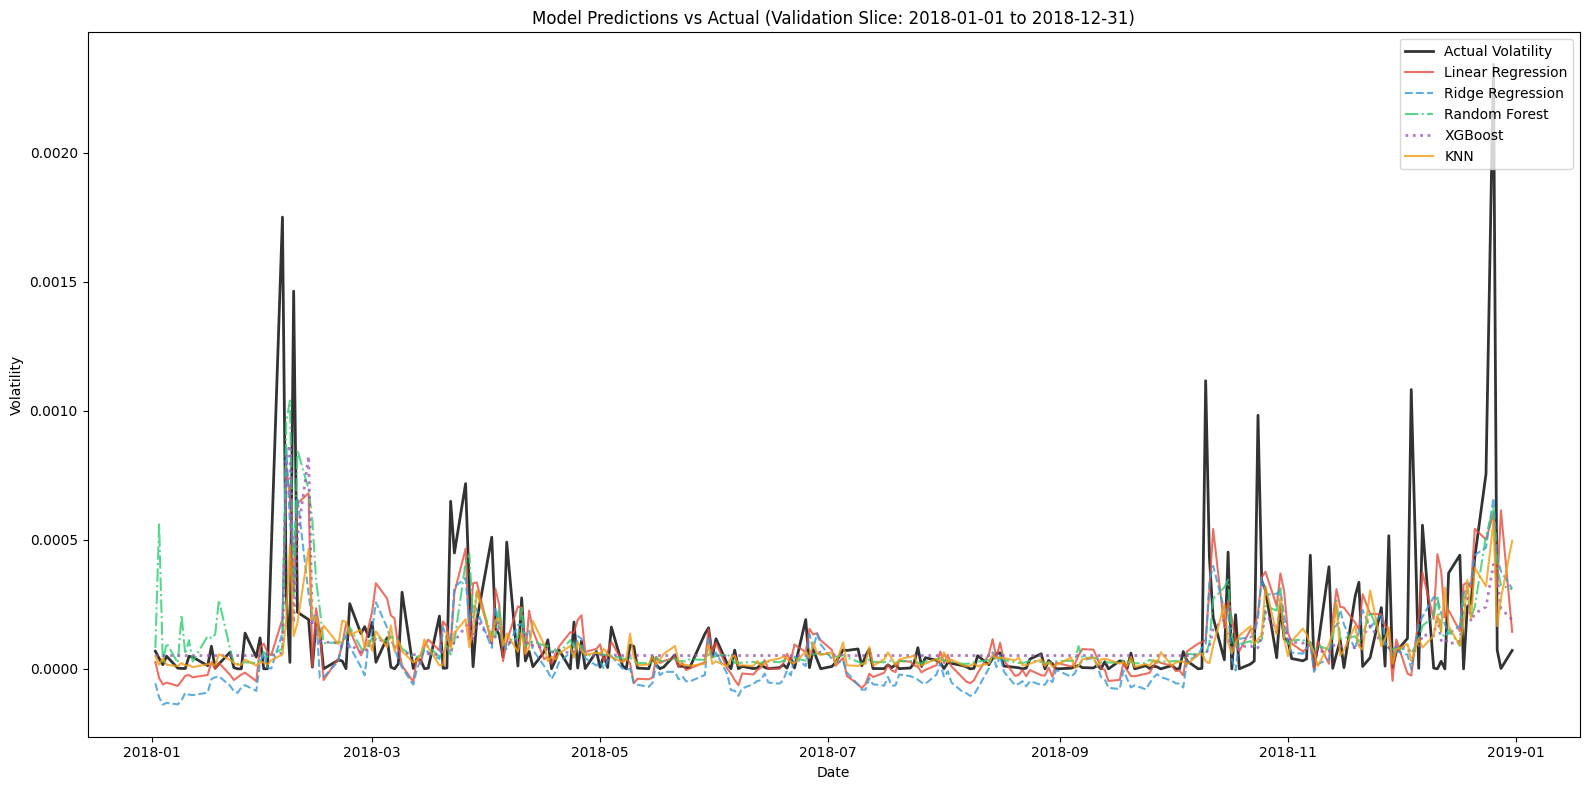

In [ ]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Train and evaluate classical ML models for volatility forecasting.
    Models: Linear Regression, Ridge, Random Forest, KNN, XGBoost
    """
    
    print(f"--- Training {name} ---")
    model.fit(X_train, y_train)
    
    pred_val = model.predict(X_val)

    mse_val = mean_squared_error(y_val, pred_val)
    mae_val = mean_absolute_error(y_val, pred_val)
    r2_val = r2_score(y_val, pred_val)

    print(f"Validation MSE: {mse_val:.8f}")
    print(f"Validation MAE: {mae_val:.8f}")
    print(f"Validation R²:  {r2_val:.6f}")
    print("-" * 30)

    return pred_val


def train_classical_models():
    """Train and evaluate linear, ridge, random forest, SVR, KNN, and XGBoost regressors."""
    input_path = os.path.join("..", "data", "processed", "sp500_ml_ready.csv")
    if not os.path.exists(input_path):
            print("Data not found.")
            return
    
    df = pd.read_csv(input_path, index_col=0, parse_dates=True)
    
    drop_cols = ['Target_Vol', 'Log_Return'] 
    feature_cols = [c for c in df.columns if c not in drop_cols and ('Lag' in c or 'Roll' in c)]

    X = df[feature_cols]
    y = df['Target_Vol']

    print(f"Features used: {feature_cols}")

    train_mask = df.index < '2015-01-01'
    val_mask = (df.index >= '2015-01-01') & (df.index < '2020-01-01')

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]

    print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    model_dir = os.path.join("..", "models")
    plot_dir = os.path.join("..", "plots")
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)

    results = {}
    
    models_no_scale = [
        ("Linear_Regression", LinearRegression()),
        ("Ridge_Regression", Ridge(alpha=1.0)),
        ("Random_Forest", RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)),
        ("XGBoost", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
    ]
    
    models_scale = [
        ("KNN", KNeighborsRegressor(n_neighbors=10, weights='distance'))
    ]

    for name, model in models_no_scale:
        results[name] = evaluate_model(name.replace("_", " "), model, X_train, y_train, X_val, y_val)
        save_path = os.path.join(model_dir, f"{name}.pkl")
        joblib.dump(model, save_path)
        print(f"Saved model to: {save_path}")

    for name, model in models_scale:
        results[name] = evaluate_model(name, model, X_train_scaled, y_train, X_val_scaled, y_val)
        save_path = os.path.join(model_dir, f"{name}.pkl")
        joblib.dump(model, save_path)
        print(f"Saved model to: {save_path}")

    joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
    print("Saved scaler to: models/scaler.pkl")

    plot_start = '2018-01-01'
    plot_end = '2018-12-31'
    val_indices = df.index[val_mask]
    plot_mask = (val_indices >= plot_start) & (val_indices <= plot_end)

    plt.figure(figsize=(16, 8))
    
    plt.plot(val_indices[plot_mask], y_val[plot_mask], label='Actual Volatility', 
             color='black', linewidth=2, alpha=0.8)

    styles = [
        {'color': '#e74c3c', 'linestyle': '-', 'linewidth': 1.5},   
        {'color': '#3498db', 'linestyle': '--', 'linewidth': 1.5}, 
        {'color': '#2ecc71', 'linestyle': '-.', 'linewidth': 1.5},  
        {'color': '#9b59b6', 'linestyle': ':', 'linewidth': 2},     
        {'color': '#f39c12', 'linestyle': '-', 'linewidth': 1.5},   
    ]

    for idx, (name, preds) in enumerate(results.items()):
        plt.plot(val_indices[plot_mask], preds[plot_mask], 
                 label=name.replace("_", " "), **styles[idx], alpha=0.8)

    plt.title(f'Model Predictions vs Actual (Validation Slice: {plot_start} to {plot_end})')
    plt.ylabel('Volatility')
    plt.xlabel('Date')
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()

    plt.savefig(os.path.join(plot_dir, "model_comparison_classical.png"), dpi=150)
    print("Saved comparison plot to plots/model_comparison_classical.png")

if __name__ == "__main__":
    train_classical_models()